Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  → Training batch 1/188
  → Training batch 2/188
  → Training batch 3/188
  → Training batch 4/188
  → Training batch 5/188
  → Training batch 6/188
  → Training batch 7/188
  → Training batch 8/188
  → Training batch 9/188
  → Training batch 10/188
  → Training batch 11/188
  → Training batch 12/188
  → Training batch 13/188
  → Training batch 14/188
  → Training batch 15/188
  → Training batch 16/188
  → Training batch 17/188
  → Training batch 18/188
  → Training batch 19/188
  → Training batch 20/188
  → Training batch 21/188
  → Training batch 22/188
  → Training batch 23/188
  → Training batch 24/188
  → Training batch 25/188
  → Training batch 26/188
  → Training batch 27/188
  → Training batch 28/188
  → Training batch 29/188
  → Training batch 30/188
  → Training batch 31/188
  → Training batch 32/188
  → Training batch 33/188
  → Training batch 34/

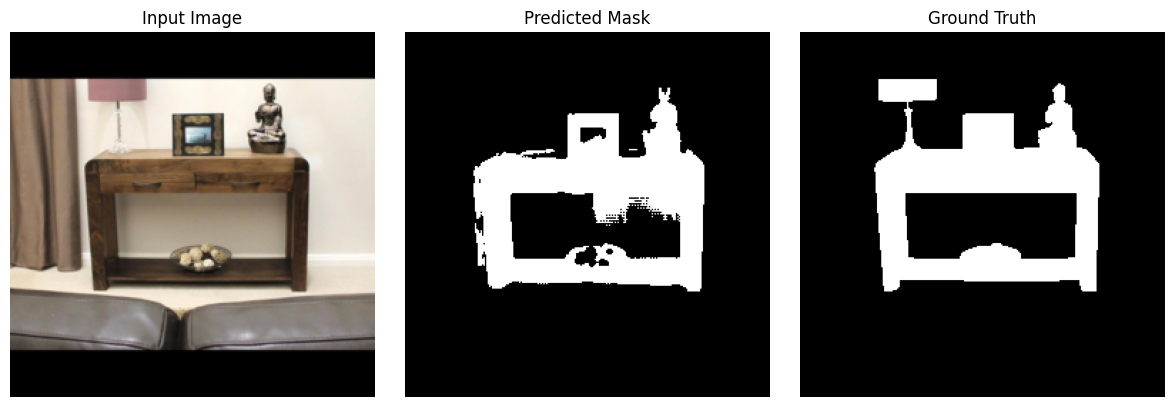

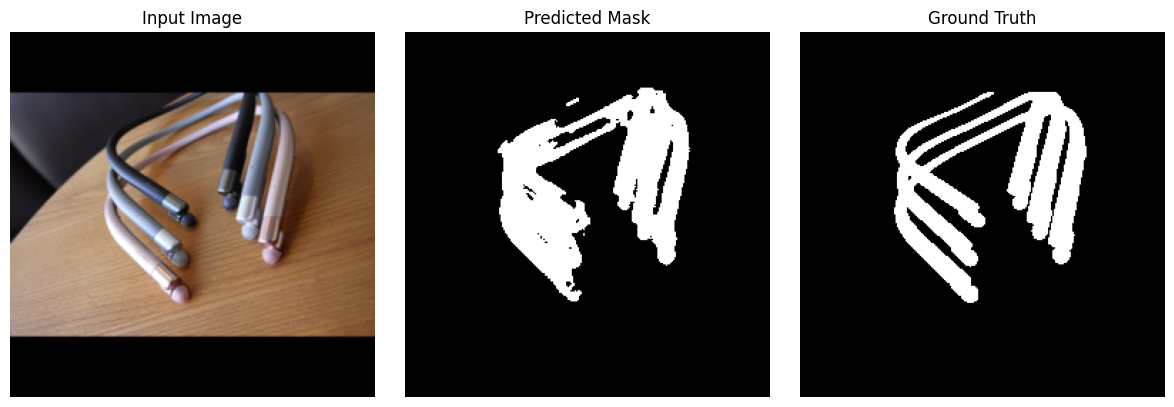

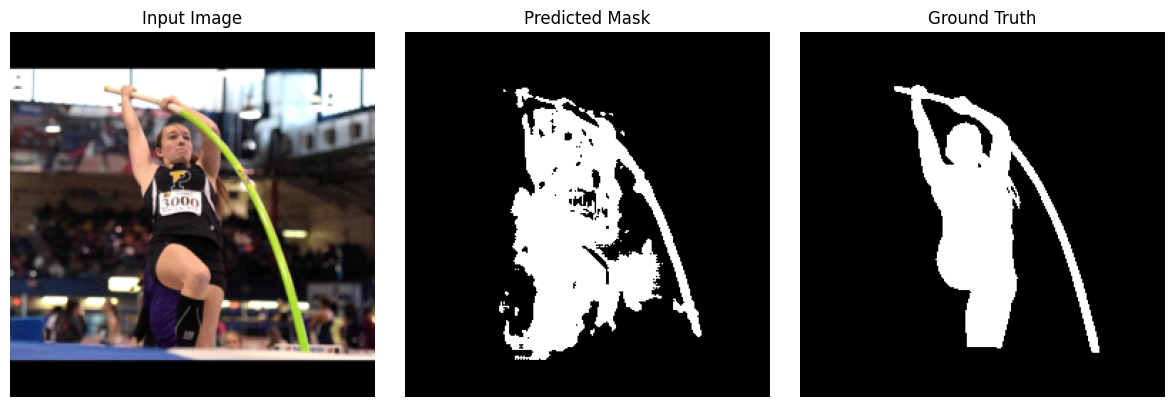

In [10]:
# === Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# ==============================
# DAWN MODULE
# ==============================
class DAWN(nn.Module):
    """
    DAWN module: Learns IPC-like filters as a trainable preprocessing layer.
    This module takes raw images and produces augmented feature maps that
    highlight edges/structures at multiple scales.
    """
    def __init__(self, in_channels: int):
        super(DAWN, self).__init__()
        self.in_channels = in_channels
        # fine-scale edge detection
        self.conv_fine = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)
        # coarse-scale structure detection
        self.conv_coarse = nn.Conv2d(in_channels, 1, kernel_size=3, padding=4, dilation=4)
        # weight initialization
        nn.init.kaiming_normal_(self.conv_fine.weight, nonlinearity='relu')
        nn.init.constant_(self.conv_fine.bias, 0.0)
        nn.init.kaiming_normal_(self.conv_coarse.weight, nonlinearity='relu')
        nn.init.constant_(self.conv_coarse.bias, 0.0)
        self.out_channels = in_channels + 2

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        fine = F.relu(self.conv_fine(x))
        coarse = F.relu(self.conv_coarse(x))
        out = torch.cat([x, fine, coarse], dim=1)
        return out


# ==============================
# U-NET
# ==============================
class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(DoubleConv, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class UNet(nn.Module):
    def __init__(self, in_channels: int, out_classes: int = 1):
        super(UNet, self).__init__()
        features = [64, 128, 256, 512]
        self.enc_blocks = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        prev_channels = in_channels
        for feat in features:
            self.enc_blocks.append(DoubleConv(prev_channels, feat))
            prev_channels = feat
        self.bottleneck = DoubleConv(prev_channels, prev_channels * 2)
        bottleneck_channels = prev_channels * 2  # store for clarity
        self.dec_blocks = nn.ModuleList()
        self.upconvs = nn.ModuleList()
        for feat in reversed(features):
            # use bottleneck_channels (1024) for the first upconv, then halve each time
            self.upconvs.append(nn.ConvTranspose2d(bottleneck_channels, feat, kernel_size=2, stride=2))
            self.dec_blocks.append(DoubleConv(feat * 2, feat))
            bottleneck_channels = feat  # update for next iteration

        self.final_conv = nn.Conv2d(features[0], out_classes, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        enc_features = []
        for enc_block in self.enc_blocks:
            x = enc_block(x)
            enc_features.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        for i, dec_block in enumerate(self.dec_blocks):
            skip_feat = enc_features[-(i+1)]
            x = self.upconvs[i](x)
            if x.shape[2:] != skip_feat.shape[2:]:
                diffY = skip_feat.size(2) - x.size(2)
                diffX = skip_feat.size(3) - x.size(3)
                x = F.pad(x, [diffX // 2, diffX - diffX//2, diffY // 2, diffY - diffY//2])
            x = torch.cat([skip_feat, x], dim=1)
            x = dec_block(x)
        logits = self.final_conv(x)
        return logits


# ==============================
# COMBINED MODEL
# ==============================
class DawnUNet(nn.Module):
    def __init__(self, in_channels: int = 3, out_classes: int = 1, use_dawn: bool = True):
        super(DawnUNet, self).__init__()
        self.use_dawn = use_dawn
        if use_dawn:
            self.dawn = DAWN(in_channels)
            self.unet = UNet(in_channels=self.dawn.out_channels, out_classes=out_classes)
        else:
            self.dawn = None
            self.unet = UNet(in_channels=in_channels, out_classes=out_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.use_dawn:
            x = self.dawn(x)
        logits = self.unet(x)
        return logits


# ==============================
# DATASET
# ==============================
class SegmentationDataset(Dataset):
    def __init__(self, images_dir: str, masks_dir: str, transform_image=None, transform_mask=None):
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))
        assert len(self.image_files) == len(self.mask_files)
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        mask = (mask > 0.5).float()
        return image, mask


# ==============================
# TRAINING AND VISUALIZATION
# ==============================
def main():
    # Drive dataset paths
    train_images = "/content/drive/MyDrive/research/unet-ipc-data/DIS-TR/im-good"
    train_masks = "/content/drive/MyDrive/research/unet-ipc-data/DIS-TR/gt-good"

    transform_img = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
    transform_mask = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

    train_dataset = SegmentationDataset(train_images, train_masks, transform_img, transform_mask)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DawnUNet(in_channels=3, out_classes=1, use_dawn=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCEWithLogitsLoss()

    model.train()
    for epoch in range(10):
        total_loss, total_dice, total_iou = 0.0, 0.0, 0.0

        for batch_idx, (images, masks) in enumerate(train_loader):
            print(f"  → Training batch {batch_idx+1}/{len(train_loader)}")
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            logits = model(images)
            loss = loss_fn(logits, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)

            # --- Dice & IoU for this batch ---
            with torch.no_grad():
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).float()
                intersection = (preds * masks).sum(dim=(1,2,3))
                union = preds.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3))
                dice = ((2 * intersection + 1e-7) / (union + 1e-7)).mean().item()
                iou = ((intersection + 1e-7) / (union - intersection + 1e-7)).mean().item()

            total_dice += dice * images.size(0)
            total_iou += iou * images.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        avg_dice = total_dice / len(train_loader.dataset)
        avg_iou = total_iou / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/20 - Loss: {avg_loss:.4f}, Dice: {avg_dice:.3f}, IoU: {avg_iou:.3f}")
        # save_path = "/content/drive/MyDrive/research/dawn_unet_DIS.pth"
        # torch.save(model.state_dict(), save_path)
        # print(f"Model saved to: {save_path}")


    # Visualization
    os.makedirs("output_viz", exist_ok=True)
    model.eval()
    with torch.no_grad():
        for idx, (img, mask) in enumerate(train_loader):
            img, mask = img.to(device), mask.to(device)
            pred = torch.sigmoid(model(img))
            pred = (pred > 0.5).float()
            img_np = img[0].cpu().permute(1, 2, 0).numpy()
            pred_np = pred[0, 0].cpu().numpy()
            mask_np = mask[0, 0].cpu().numpy()
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(img_np)
            axs[0].set_title("Input Image")
            axs[1].imshow(pred_np, cmap="gray")
            axs[1].set_title("Predicted Mask")
            axs[2].imshow(mask_np, cmap="gray")
            axs[2].set_title("Ground Truth")
            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.savefig(f"output_viz/sample_{idx}.png")
            plt.show()
            plt.close()
            if idx >= 2:
                break

if __name__ == "__main__":
    main()


In [12]:
# ==============================
# Testing on a subset + progress prints
# ==============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Same dataset used for training — TEMP until DIS-TE fixed
test_images = "/content/drive/MyDrive/research/unet-ipc-data/DIS-TR/im-good"
test_masks  = "/content/drive/MyDrive/research/unet-ipc-data/DIS-TR/gt-good"

# IMPORTANT ✅ reuse same transforms you defined above
# transform_img, transform_mask exist from training

test_dataset = SegmentationDataset(test_images, test_masks, transform_img, transform_mask)

# ✅ Only test on first 750 to match your training choice
subset_size = 750
test_dataset = torch.utils.data.Subset(test_dataset, range(min(subset_size, len(test_dataset))))

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
total_iou = 0.0

print(f"🔍 Evaluating {len(test_dataset)} samples…")

with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        images, masks = images.to(device), masks.to(device)
        logits = model(images)
        preds = (torch.sigmoid(logits) > 0.5).float()

        intersection = (preds * masks).sum()
        union = preds.sum() + masks.sum()
        iou = (intersection + 1e-7) / (union - intersection + 1e-7)
        total_iou += iou.item()

        print(f"Completed {i+1}/{len(test_loader)} — IoU: {iou.item():.3f}")

avg_iou = total_iou / len(test_loader)
print(f"\n🎯 Final Average IoU (750-sample subset): {avg_iou:.3f}")


🔍 Evaluating 750 samples…
Completed 1/750 — IoU: 0.939
Completed 2/750 — IoU: 0.918
Completed 3/750 — IoU: 0.872
Completed 4/750 — IoU: 0.776
Completed 5/750 — IoU: 0.665
Completed 6/750 — IoU: 0.024
Completed 7/750 — IoU: 0.854
Completed 8/750 — IoU: 0.781
Completed 9/750 — IoU: 0.490
Completed 10/750 — IoU: 0.798
Completed 11/750 — IoU: 0.857
Completed 12/750 — IoU: 0.616
Completed 13/750 — IoU: 0.856
Completed 14/750 — IoU: 0.559
Completed 15/750 — IoU: 0.614
Completed 16/750 — IoU: 0.769
Completed 17/750 — IoU: 0.728
Completed 18/750 — IoU: 0.640
Completed 19/750 — IoU: 0.811
Completed 20/750 — IoU: 0.625
Completed 21/750 — IoU: 0.658
Completed 22/750 — IoU: 0.706
Completed 23/750 — IoU: 0.871
Completed 24/750 — IoU: 0.377
Completed 25/750 — IoU: 0.842
Completed 26/750 — IoU: 0.576
Completed 27/750 — IoU: 0.794
Completed 28/750 — IoU: 0.695
Completed 29/750 — IoU: 0.423
Completed 30/750 — IoU: 0.693
Completed 31/750 — IoU: 0.784
Completed 32/750 — IoU: 0.703
Completed 33/750 — IoU: